In [1]:
!pip install pandas numpy statsmodels


In [2]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency


# Data Generation

In [3]:
import pandas as pd
import numpy as np

# Seed for reproducibility
np.random.seed(42)

# Constants
num_users = 25000
start_date = '2016-03-04'
end_date = '2016-08-31'
split_date = '2016-06-01'
dates = pd.date_range(start_date, end_date)

# Age and Gender distributions
ages = np.random.randint(18, 65, num_users)
genders = np.random.choice(['Male', 'Female'], num_users)

# Device types and Cities within the US
devices = np.random.choice(['Smartphone', 'Tablet', 'Desktop'], num_users)
cities = np.random.choice(['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix'], num_users)

# Generate trends for DAU/MAU
pre_control_trend = np.linspace(0.67, 0.665, len(dates) // 2)
post_control_trend = np.linspace(0.665, 0.66, len(dates) - len(dates) // 2)
control_trend = np.concatenate([pre_control_trend, post_control_trend])

pre_treatment_trend = np.linspace(0.671, 0.666, len(dates) // 2)
post_treatment_trend = np.linspace(0.666, 0.666 * 1.20, len(dates) - len(dates) // 2)
treatment_trend = np.concatenate([pre_treatment_trend, post_treatment_trend])

# Add random noise for variability
control_trend += np.random.normal(0, 0.0005, len(control_trend))
treatment_trend += np.random.normal(0, 0.0005, len(treatment_trend))

# Standard interactions trend (decreasing)
interaction_trend = np.linspace(10, 5, len(dates))
interaction_trend += np.random.normal(0, 0.5, len(dates))  # Adding some noise
interaction_trend = np.clip(interaction_trend, 3, None)  # Prevent falling below 3

# Story interactions (only for treatment group post-feature introduction)
story_interaction_trend = np.zeros_like(interaction_trend)
post_feature_start_index = np.where(dates >= pd.to_datetime(split_date))[0][0]
story_interaction_trend[post_feature_start_index:] = np.linspace(1, 3, len(dates) - post_feature_start_index)  # Increasing trend post-feature
story_interaction_trend += np.random.normal(0, 0.3, len(dates))  # Adding some noise
story_interaction_trend = np.clip(story_interaction_trend, 0, None)  # No negative interactions

# Assign groups to user IDs
user_ids = np.arange(1, num_users + 1)
treatment_users = np.random.choice(user_ids, size=num_users // 2, replace=False)
group_assignment = np.where(np.isin(user_ids, treatment_users), 'Treatment', 'Control')

# Create the dataframe
df = pd.DataFrame({
    'Date': np.tile(dates, num_users),
    'USER_ID': np.repeat(user_ids, len(dates)),
    'Age': np.repeat(ages, len(dates)),
    'Gender': np.repeat(genders, len(dates)),
    'Device': np.repeat(devices, len(dates)),
    'City': np.repeat(cities, len(dates)),
    'Group': np.repeat(group_assignment, len(dates)),
    'Standard_Interactions': np.tile(interaction_trend, num_users),
    'Story_Interactions': np.tile(story_interaction_trend, num_users),
    'DAU/MAU': np.nan  # Placeholder for DAU/MAU values
})

# Assign DAU/MAU and interactions only to appropriate groups
df.loc[df['Group'] == 'Control', 'DAU/MAU'] = np.tile(control_trend, num_users // 2)
df.loc[df['Group'] == 'Treatment', 'DAU/MAU'] = np.tile(treatment_trend, num_users // 2)
df.loc[df['Group'] == 'Control', 'Story_Interactions'] = 0  # No story interactions for control group

df.to_csv('full_facebook_data.csv')

In [4]:
df.describe()

,Date,USER_ID,Age,Standard_Interactions,Story_Interactions,DAU/MAU
count,4525000,4.525000e+06,4.525000e+06,4.525000e+06,4.525000e+06,4.525000e+06
mean,2016-06-01 23:59:59.999999232,1.250050e+04,4.093172e+01,7.466612e+00,5.430920e-01,6.828698e-01
min,2016-03-04 00:00:00,1.000000e+00,1.800000e+01,4.107556e+00,0.000000e+00,6.595185e-01
25%,2016-04-18 00:00:00,6.250750e+03,2.900000e+01,6.223938e+00,0.000000e+00,6.648945e-01
50%,2016-06-02 00:00:00,1.250050e+04,4.100000e+01,7.388469e+00,0.000000e+00,6.680523e-01
75%,2016-07-17 00:00:00,1.875025e+04,5.300000e+01,8.869758e+00,8.399266e-01,6.708662e-01
max,2016-08-31 00:00:00,2.500000e+04,6.400000e+01,1.064975e+01,3.865505e+00,8.001401e-01
std,NaN,7.216879e+03,1.351056e+01,1.575229e+00,9.373497e-01,3.490540e-02


In [5]:
#df = pd.read_csv('full_facebook_data.csv') uncomment if you want to skip data generation and use pregenerated / uploaded data
data = df

In [6]:
data

,Date,USER_ID,Age,Gender,Device,City,Group,Standard_Interactions,Story_Interactions,DAU/MAU
0,2016-03-04,1,56,Male,Smartphone,Los Angeles,Treatment,10.012660,0.036461,0.670600
1,2016-03-05,1,56,Male,Smartphone,Los Angeles,Treatment,9.799793,0.573546,0.671759
2,2016-03-06,1,56,Male,Smartphone,Los Angeles,Treatment,9.915978,0.314440,0.670884
3,2016-03-07,1,56,Male,Smartphone,Los Angeles,Treatment,9.647767,0.075878,0.671010
4,2016-03-08,1,56,Male,Smartphone,Los Angeles,Treatment,9.859386,0.000000,0.670468
...,...,...,...,...,...,...,...,...,...,...
4524995,2016-08-27,25000,29,Female,Tablet,Los Angeles,Control,5.148770,0.000000,0.660371
4524996,2016-08-28,25000,29,Female,Tablet,Los Angeles,Control,4.520756,0.000000,0.659991
4524997,2016-08-29,25000,29,Female,Tablet,Los Angeles,Control,4.731432,0.000000,0.660238
4524998,2016-08-30,25000,29,Female,Tablet,Los Angeles,Control,4.339178,0.000000,0.659519


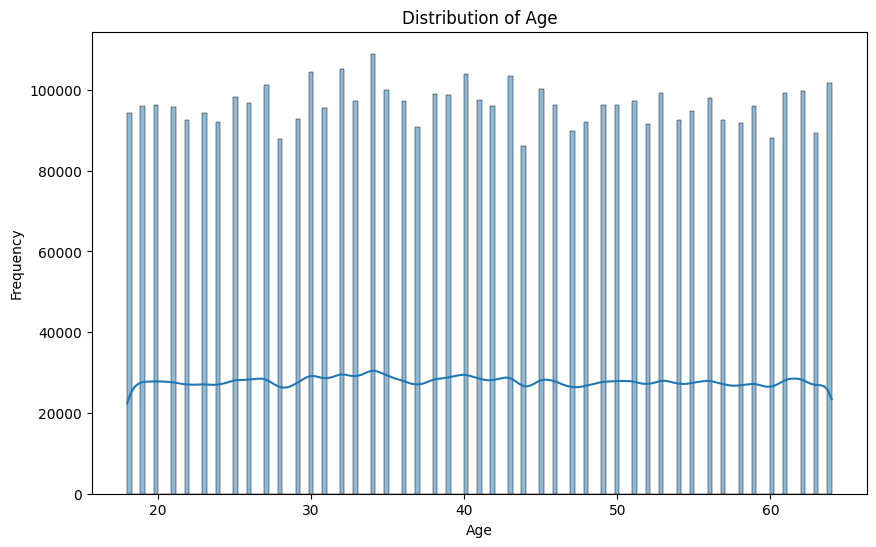

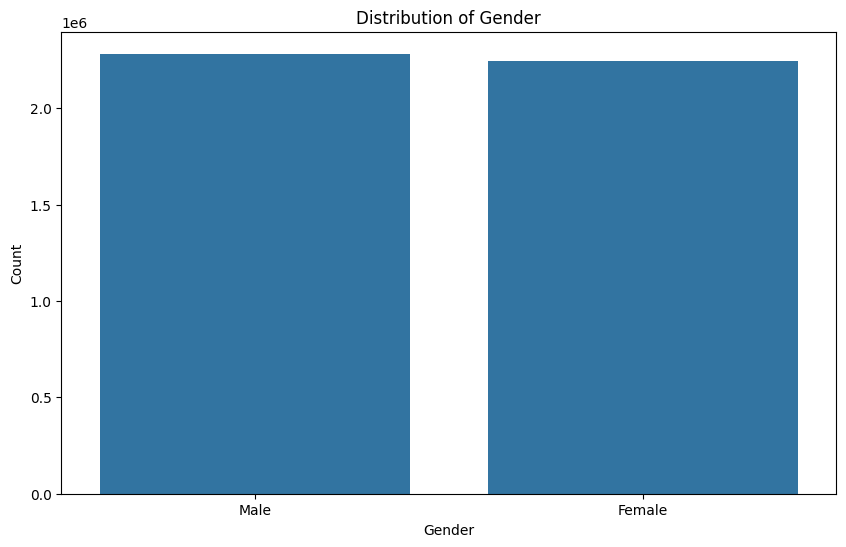

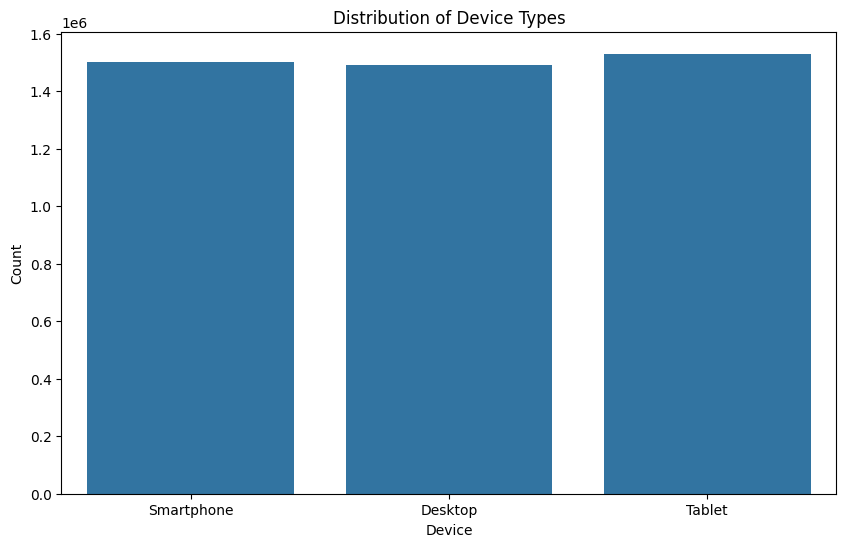

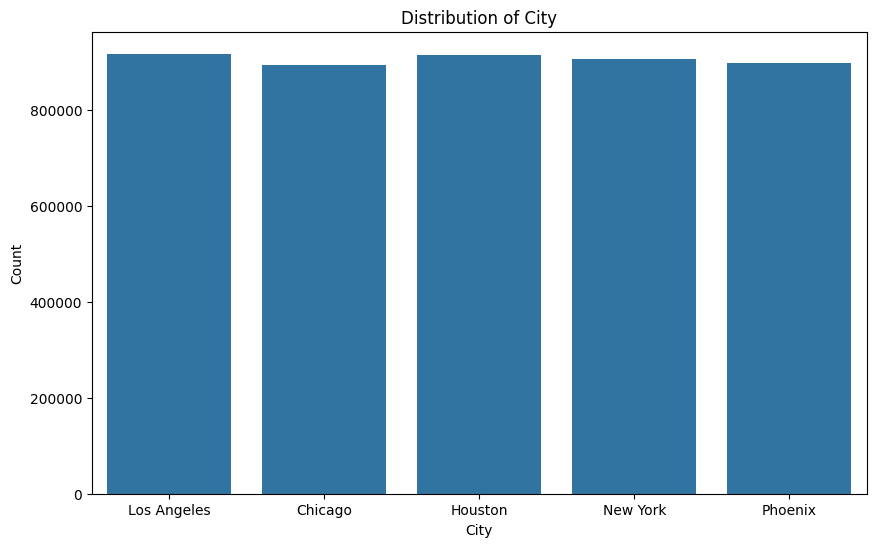

In [7]:
# Plot distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Gender distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', data=df)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Device type distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Device', data=df)
plt.title('Distribution of Device Types')
plt.xlabel('Device')
plt.ylabel('Count')
plt.show()

# City distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='City', data=df)
plt.title('Distribution of City')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()


# Plotting the trends

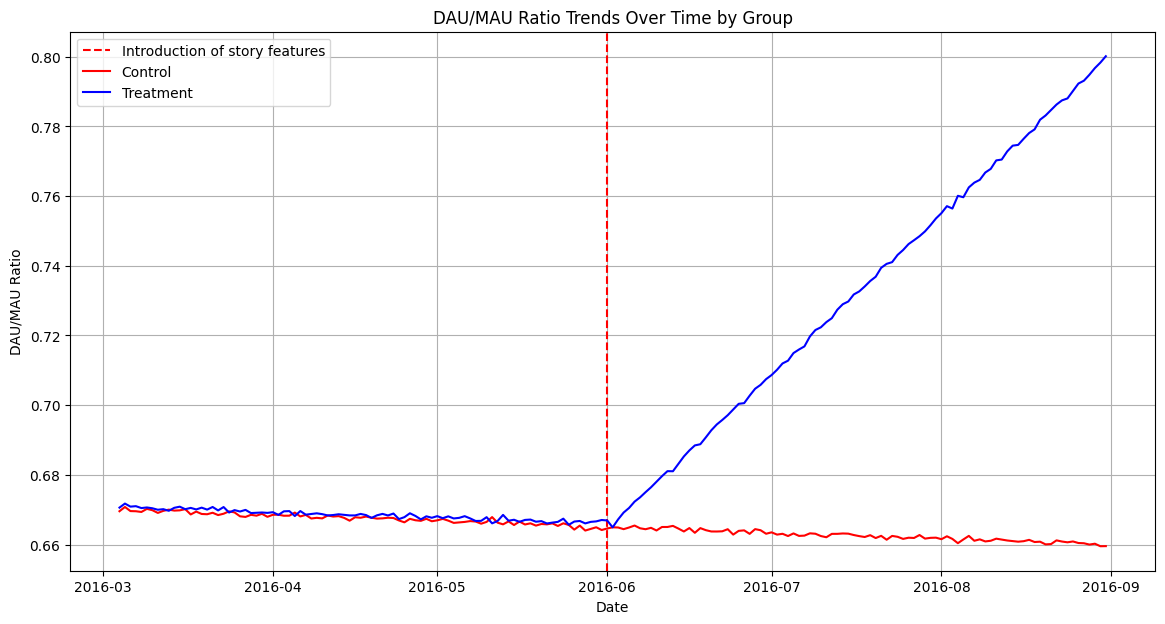

In [8]:


# Ensure 'Date' is a datetime type for proper plotting
df['Date'] = pd.to_datetime(df['Date'])

# Group the data and calculate mean DAU/MAU for each date per group
grouped_data = df.groupby(['Date', 'Group'])['DAU/MAU'].mean().reset_index()

# Pivot the data to have dates on the index and groups as columns
pivot_data = grouped_data.pivot(index='Date', columns='Group', values='DAU/MAU')

# Plot the data
plt.figure(figsize=(14, 7))

# add cutpoint 2016-06-01
plt.axvline(pd.Timestamp('2016-06-01'), color='red', linestyle='--', label='Introduction of story features')

plt.plot(pivot_data.index, pivot_data['Control'], label='Control', color='red')
plt.plot(pivot_data.index, pivot_data['Treatment'], label='Treatment', color='blue')

plt.title('DAU/MAU Ratio Trends Over Time by Group')
plt.xlabel('Date')
plt.ylabel('DAU/MAU Ratio')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Calculate daily engagement rate for a given group
def calculate_daily_engagement_rate(test_period_df):
    # Calculate daily interactions per active user
    daily_grouped = test_period_df.groupby(['Date', 'Group'])
    daily_engagement = daily_grouped.apply(
        lambda x: ((x['Standard_Interactions'] + x['Story_Interactions']).sum() / x['USER_ID'].nunique())
    ).unstack(level='Group')  # This creates a DataFrame where each group's results are in a column
    return daily_engagement

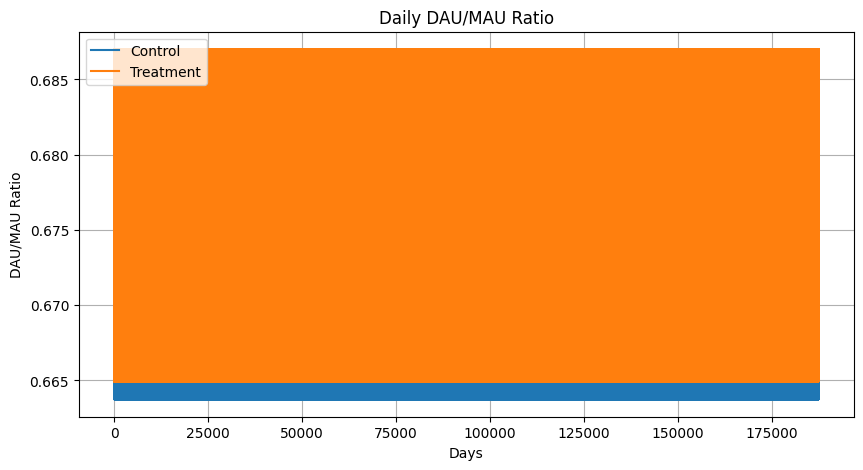

Average DAU/MAU Ratio - Control: 0.6647
Average DAU/MAU Ratio - Treatment: 0.6763
P-value from t-test: 0.0000
Average Difference: 0.0116
95% Confidence Interval for the Difference: [0.0115284199711661, 0.01158688534494762]


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, sem
import matplotlib.pyplot as plt

# Assuming 'df' is already loaded with your data as previously described
start_test_date = pd.Timestamp('2016-06-02')
end_test_date = pd.Timestamp('2016-06-16')

# Filter data for the test period for both groups
test_period_df = df[(df['Date'] >= start_test_date) & (df['Date'] <= end_test_date)]

# Get daily DAU/MAU data
daily_dau_mau = {
    'Control': test_period_df[test_period_df['Group'] == 'Control']['DAU/MAU'],
    'Treatment': test_period_df[test_period_df['Group'] == 'Treatment']['DAU/MAU']
}

average_dau_mau_control = daily_dau_mau['Control'].mean()
average_dau_mau_treatment = daily_dau_mau['Treatment'].mean()

# Perform t-test on daily DAU/MAU ratios
stat, p_value = ttest_ind(
    daily_dau_mau['Control'].dropna(),
    daily_dau_mau['Treatment'].dropna(),
    equal_var=False  # Assumes variances are not equal, uses Welch’s t-test
)

avg_difference = average_dau_mau_treatment - average_dau_mau_control
control_sem = sem(daily_dau_mau['Control'].dropna())
treatment_sem = sem(daily_dau_mau['Treatment'].dropna())

# Calculate the standard error on the difference in means
pooled_se = np.sqrt(control_sem**2 + treatment_sem**2)

# Confidence interval calculation, typically at 95% confidence level
confidence_interval = [avg_difference - 1.96 * pooled_se, avg_difference + 1.96 * pooled_se]

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(daily_dau_mau['Control'].dropna().reset_index(drop=True), label='Control')
plt.plot(daily_dau_mau['Treatment'].dropna().reset_index(drop=True), label='Treatment')
plt.title('Daily DAU/MAU Ratio')
plt.xlabel('Days')
plt.ylabel('DAU/MAU Ratio')
plt.legend()
plt.grid(True)
plt.show()

print(f"Average DAU/MAU Ratio - Control: {average_dau_mau_control:.4f}")
print(f"Average DAU/MAU Ratio - Treatment: {average_dau_mau_treatment:.4f}")
print(f"P-value from t-test: {p_value:.4f}")
print(f"Average Difference: {avg_difference:.4f}")
print(f"95% Confidence Interval for the Difference: {confidence_interval}")


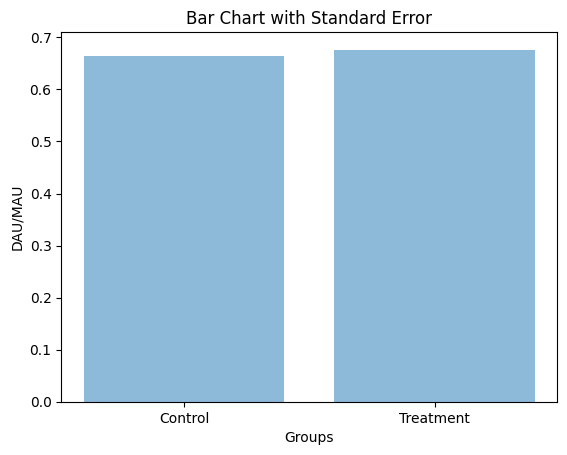

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, sem
import matplotlib.pyplot as plt

# Mean values and standard errors for C (Control) and T (Treatment) groups
# Assuming 'df' is already loaded with your data as previously described
start_test_date = pd.Timestamp('2016-06-02')
end_test_date = pd.Timestamp('2016-06-16')

# Filter data for the test period for both groups
test_period_df = df[(df['Date'] >= start_test_date) & (df['Date'] <= end_test_date)]

# Get daily DAU/MAU data
daily_dau_mau = {
    'Control': test_period_df[test_period_df['Group'] == 'Control']['DAU/MAU'],
    'Treatment': test_period_df[test_period_df['Group'] == 'Treatment']['DAU/MAU']
}

average_dau_mau_control = daily_dau_mau['Control'].mean()
average_dau_mau_treatment = daily_dau_mau['Treatment'].mean()

#control_sem = sem(daily_dau_mau['Control'].dropna())
#treatment_sem = sem(daily_dau_mau['Treatment'].dropna())

# Labels and positions
labels = ['Control', 'Treatment']
x_pos = np.arange(len(labels))

# Mean values
means = [average_dau_mau_control, average_dau_mau_treatment]

# Standard errors
#standard_errors = [control_sem, treatment_sem]

# Plotting the bar chart with error bars (standard errors)
plt.bar(x_pos, means, align='center', alpha=0.5, capsize=10)

# Adding title and labels
plt.xlabel('Groups')
plt.ylabel('DAU/MAU')
plt.title('Bar Chart with Standard Error')

# Setting x-axis labels
plt.xticks(x_pos, labels)

# Displaying the plot
plt.show()

## Key Results from A/B test:
## DAU/MAU Ratios:
### Control Group: The average DAU/MAU ratio is approximately 0.6648.
Treatment Group: The average DAU/MAU ratio is approximately 0.6765.
Difference in Ratios:
There is a significant increase in the DAU/MAU ratio in the treatment group compared to the control group, with an average difference of approximately 0.0117.
### Statistical Significance:
The p-value from the t-test is 0.0000, indicating that the difference in the DAU/MAU ratios between the control and treatment groups is statistically significant. This suggests that the probability of observing such a difference by chance is extremely low, far below the conventional threshold of 0.05 for declaring statistical significance.
### Confidence Interval:
The 95% confidence interval for the difference in DAU/MAU ratios is very narrow, ranging from approximately 0.0117 to 0.0118. This tight interval indicates a high level of precision in the estimate of the effect size, reinforcing the reliability of the test results.
### Interpretation and Implications:
* Effect of the Treatment: The treatment seems to have a positive effect on user engagement as measured by the DAU/MAU ratio. An increase in this ratio implies that either daily active usage has increased, monthly active usage has decreased less sharply, or a combination of both, indicating enhanced user engagement or retention on a daily basis relative to monthly usage.
* Practical Significance: Although the numerical difference in the DAU/MAU ratios might appear small (0.0117), the context of the test and the scale of the application should determine the practical significance. In large-scale applications, even small improvements can have substantial impacts on user experience and business outcomes.
* Decision Making: Given the statistical and practical significance of the results, it may be advisable for the decision-makers to consider implementing the treatment more broadly, assuming it is cost-effective and aligns with broader strategic goals.

## Robustness check through Segmentation Analysis:

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, sem

# Assuming 'df' is already loaded with your data as previously described
start_test_date = pd.Timestamp('2016-06-02')
end_test_date = pd.Timestamp('2016-06-16')

# Filter data for the test period for both groups
test_period_df = df[(df['Date'] >= start_test_date) & (df['Date'] <= end_test_date)]

# Define age groups
def categorize_age(age):
    if age <= 34:
        return 'Young'
    elif age <= 54:
        return 'Middle-aged'
    else:
        return 'Senior'

# Apply age group categorization
test_period_df['Age_Group'] = test_period_df['Age'].apply(categorize_age)

# Define a function to perform t-test, calculate average DAU/MAU per segment, and compute confidence intervals
def analyze_segment(segment):
    print(f"\nAnalysis for Segment: {segment}")
    segments = test_period_df[segment].unique()
    for seg in segments:
        segment_data = test_period_df[test_period_df[segment] == seg]
        control_data = segment_data[segment_data['Group'] == 'Control']['DAU/MAU'].dropna()
        treatment_data = segment_data[segment_data['Group'] == 'Treatment']['DAU/MAU'].dropna()

        average_dau_mau_control = control_data.mean()
        average_dau_mau_treatment = treatment_data.mean()
        stat, p_value = ttest_ind(control_data, treatment_data, equal_var=False)

        # Calculate the standard error on the difference in means
        control_sem = sem(control_data)
        treatment_sem = sem(treatment_data)
        pooled_se = np.sqrt(control_sem**2 + treatment_sem**2)

        # Confidence interval calculation, typically at 95% confidence level
        confidence_interval = [average_dau_mau_treatment - average_dau_mau_control - 1.96 * pooled_se,
                               average_dau_mau_treatment - average_dau_mau_control + 1.96 * pooled_se]

        print(f"  {seg} - Control Avg: {average_dau_mau_control:.4f}, Treatment Avg: {average_dau_mau_treatment:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  95% Confidence Interval: {confidence_interval}")

# Perform the analysis for the 'Age_Group', 'Gender', and 'Device' segments
for segment in ['Age_Group', 'Gender', 'Device']:
    analyze_segment(segment)


<ipython-input-13-c1309afbdb53>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_period_df['Age_Group'] = test_period_df['Age'].apply(categorize_age)



Analysis for Segment: Age_Group
  Senior - Control Avg: 0.6647, Treatment Avg: 0.6763
  P-value: 0.0000
  95% Confidence Interval: [0.011493570427844518, 0.011621734888269203]
  Middle-aged - Control Avg: 0.6647, Treatment Avg: 0.6763
  P-value: 0.0000
  95% Confidence Interval: [0.011512603270569037, 0.011602702045544684]
  Young - Control Avg: 0.6647, Treatment Avg: 0.6763
  P-value: 0.0000
  95% Confidence Interval: [0.011509647294621235, 0.011605658021492708]

Analysis for Segment: Gender
  Male - Control Avg: 0.6647, Treatment Avg: 0.6763
  P-value: 0.0000
  95% Confidence Interval: [0.011516410870997503, 0.011598894445116218]
  Female - Control Avg: 0.6647, Treatment Avg: 0.6763
  P-value: 0.0000
  95% Confidence Interval: [0.011516210963926571, 0.01159909435218715]

Analysis for Segment: Device
  Smartphone - Control Avg: 0.6647, Treatment Avg: 0.6763
  P-value: 0.0000
  95% Confidence Interval: [0.011507086884264715, 0.011608218431849228]
  Desktop - Control Avg: 0.6647, Treat